In [1]:
import pdb # needs conda install
import os # base python
import pickle # base python
import json # base python
import pandas as pd # needs conda install
import numpy as np # needs conda install
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp # needs conda install
import scipy
from matplotlib import pyplot as plt # needs conda install
import seaborn as sns # needs conda install
import math # base python
from sklearn.metrics import adjusted_rand_score # needs conda install

sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22


from humanUtils import * # no conda needed
from cswHumanDatabase import load_final_df, load_dfs # no conda needed
from analysis import * # no conda needed
from utils import * # no conda needed

condL = ['blocked','interleaved','early','middle','late']
%load_ext autoreload
%autoreload 2

# constants

In [2]:
V1 = 'gs0317'
V2 = 'gs0317_concentrationAcross'
V9 = 'gs0317_version9_concentrationAcross_skipt1False_except_blocked'
V5 = 'gs0317_version5_skipt1False'

cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','purple','purple','red'],
  'early': ['blue','green','purple','purple','red'],
  'inserted_early_rep': ['blue','green','purple','purple','red'],
  'inserted_middle': ['purple','blue','green','purple','red'],
  'middle': ['purple','blue','green','purple','red'],
  'inserted_middle_rep': ['purple','blue','green','purple','red'],
  'inserted_late': ['purple','purple','blue','green','red'],
  'late': ['purple','purple','blue','green','red'],
  'inserted_late_rep': ['purple','purple','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False

# human dataframe

## load and save dataframes from each experiemnt

In [3]:
## load and save
recompute = False
dfD = {}
for cond in ALL_CONDITIONS:
  for thresh in [0.9,0]:
    print(cond)
    fname = f"{cond}_thresh{int(thresh*100)}.csv"
    if recompute:
      df = load_final_df(cond,threshold=thresh) 
      df.to_csv(f'data_csv/human/{fname}')
    df = pd.read_csv(f'data_csv/human/{fname}')
    dfD[cond,thresh] = df

human_df = pd.concat(dfD,names=['condition','thresh'])

blocked
blocked
interleaved
interleaved
blocked_rep
blocked_rep
interleaved_rep
interleaved_rep
explicit_interleaved
explicit_interleaved
inserted_early
inserted_early
inserted_middle
inserted_middle
inserted_late
inserted_late
inserted_early_rep
inserted_early_rep
inserted_middle_rep
inserted_middle_rep
inserted_late_rep
inserted_late_rep


## additional formating to human df

In [4]:
# additional columns
human_df.loc[:,'score'] = human_df.correct_response
human_df.loc[:,'response_node'] = human_df.apply(lambda r: [r.false_tonode,r.true_tonode][r.correct_response],axis=1)
node2stateD = {
  "BEGIN":0,
  "LOCNODEB":1,
  "LOCNODEC":2,
  "NODE11":3,
  "NODE12":4,
  "NODE21":5,
  "NODE22":6,
  "NODE31":7,
  "NODE32":8,
  "END":9
}
human_df.loc[:,'rfc_int'] = (human_df.true_rfc.str.split('-').str[-1].str.lower()=='jungle').astype('int')
human_df.loc[:,'response_node_int'] = human_df.apply(lambda r: node2stateD[r.response_node],axis=1)
# finalize
human_df = human_df.reset_index()
print(human_df.columns)
human_df.head()



Index(['condition', 'thresh', 'level_2', 'subjnum', 'block', 'story', 'depth',
       'Unnamed: 4', 'type', 'qtype', 'state', 'fromnode', 'true_tonode',
       'false_tonode', 'rfc', 'true_rfc', 'false_rfc', 'response_right',
       'true_on_right', 'correct_response', 'edge', 'score', 'response_node',
       'rfc_int', 'response_node_int'],
      dtype='object')


condition  thresh  level_2  subjnum  block  story  depth  Unnamed: 4  \
0   blocked     0.9        0        6      0      0      1          11   
1   blocked     0.9        1        6      0      0      2          15   
2   blocked     0.9        2        6      0      1      1          30   
3   blocked     0.9        3        6      0      1      2          34   
4   blocked     0.9        4        6      0      2      1          49   

       type   qtype  ...                         true_rfc  \
0  question  transQ  ...  subject-Beverly_location-jungle   
1  question  transQ  ...  subject-Beverly_location-jungle   
2  question  transQ  ...    subject-Jacob_location-jungle   
3  question  transQ  ...    subject-Jacob_location-jungle   
4  question  transQ  ...   subject-Denise_location-jungle   

                         false_rfc response_right true_on_right  \
0  subject-Beverly_location-jungle           True         False   
1  subject-Beverly_location-jungle           True         False   
2    subject-Jacob_location-jungle           True          True   
3    subject-Jacob_location-jungle           True          True   
4   subject-Denise_location-jungle           True          True   

   correct_response          edge score  response_node  rfc_int  \
0                 0  NODE11NODE22     0         NODE21        1   
1                 0  NODE22NODE31     0         NODE32        1   
2                 1  NODE11NODE22     1         NODE22        1   
3                 1  NODE22NODE31     1         NODE31        1   
4                 1  NODE11NODE22     1         NODE22        1   

   response_node_int  
0                  5  
1                  8  
2                  6  
3                  7  
4                  6  

[5 rows x 25 columns]

# plots organized by flow

In [5]:
fig_save_path = "../../../figures_paper/"

In [56]:
def lineplt_single(cond,thresh,transition=None,ax=None,fgkw={},figname="none"):
  plt.figure(figsize=(12,6))
  condL=[cond]
  if not ax:
    ax = plt.gca()
  df_plt = human_df.query("condition==@condL&thresh==thresh").reset_index()
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  g = sns.lineplot(data=df_plt,x='story',y='score',ax=ax,**fgkw)
  ax.axhline(0.5,c='k')
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('trial')
  # background color
  color_background(ax,cond)
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  plt.savefig(fig_save_path+'png/human/lineplt_%s-thresh_%.2f-transition_%s.png'%(cond,thresh,str(transition)))
  plt.savefig(fig_save_path+'svg/%s--lineplt_%s-thresh_%.2f-transition_%s.svg'%(figname,cond,thresh,str(transition)))
  return g

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplt(condL,thresh,transition=None,ax=None,fgkw={},figname="none"):
  for cond in condL:
    lineplt_single(cond,thresh,transition=transition,ax=ax,fgkw=fgkw,figname=figname)

def beetestplt(condL,thresh,transition=None,figname="none"):
  plt.figure(figsize=(12,6))
  ax = plt.gca()
  df_plt = human_df.query(f"condition==@condL&thresh=={thresh}").reset_index()
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  dftest_plt = df_plt.query("block==4")
  g = sns.violinplot(data=dftest_plt.groupby(['subjnum','condition']).mean().reset_index(),
                x='condition',y='score',hue_order='condition',ax=ax,order=condL
               )
  ax.set_ylabel('prediction accuracy')
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  plt.savefig(fig_save_path+'png/human/violin-%s-thresh%.2f-transition_%s.png'%(condL,thresh,str(transition)))
  plt.savefig(fig_save_path+'svg/%s--violin-%s-thresh%.2f-transition_%s.svg'%(figname,condL,thresh,str(transition)))
  return g

### BI 

* ross 1: human blocked performance (should match upper-left part of Fig. 3 in Andre paper)
* ross 2: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper)
- ross 3: beeswarm plot of blocked and interleaved test accuracy (each dot is a participant; separate “beeswarms” for each condition)
- ross 4: beeswarm plot of blocked and interleaved test accuracy, including all participants (not just the “90% filtered” participants)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

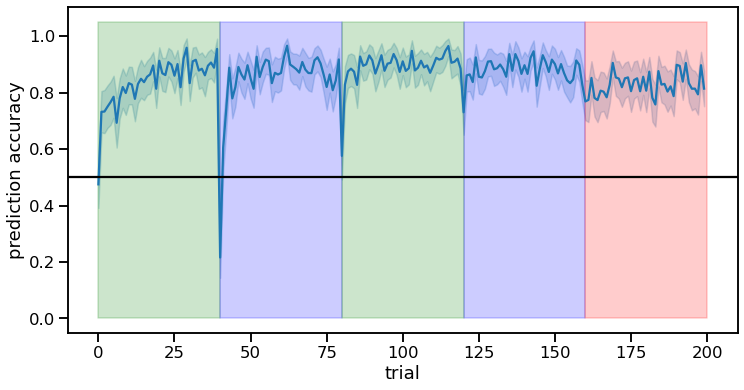

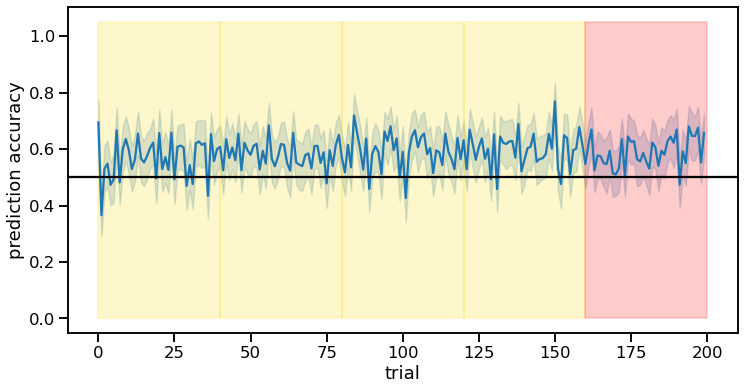

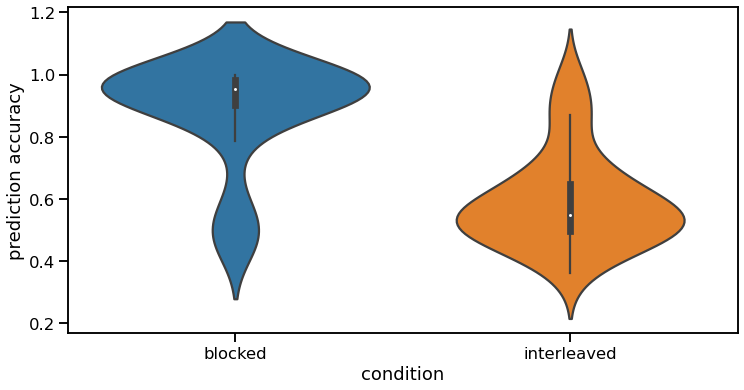

In [57]:
n = 'humanBI'
lineplt(['blocked','interleaved'],0.9,figname=n)
beetestplt(['blocked','interleaved'],0.9,figname=n)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

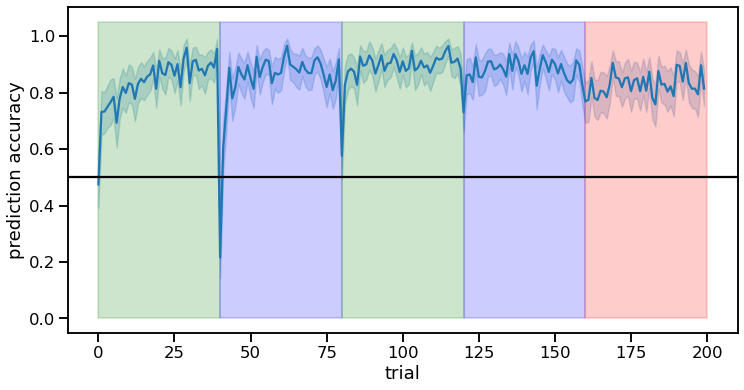

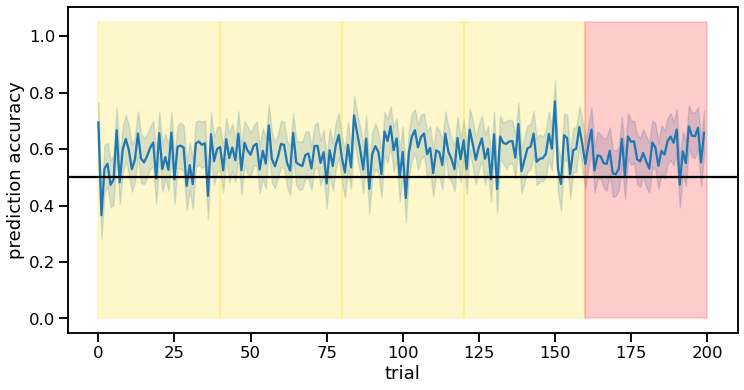

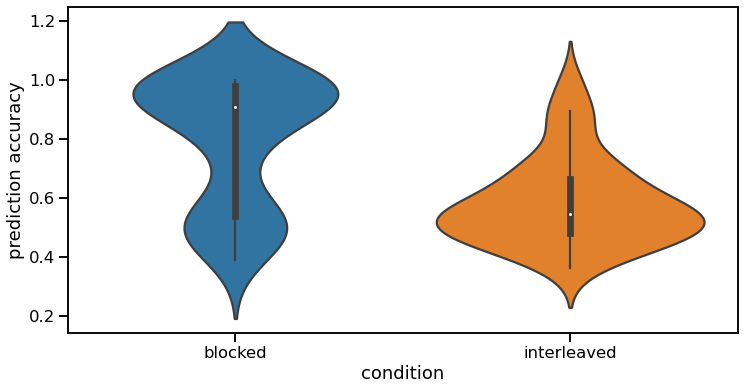

In [61]:
n='humanBInofilt'
lineplt(['blocked','interleaved'],0.0,figname=n)
beetestplt(['blocked','interleaved'],0.0,figname=n)

### BIrep
- ross 5: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper)
- ross 6: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper)
- ross 7: beeswarm plot of blocked-replication and interleaved-replication test accuracy (each dot is a participant; separate “beeswarms” for each condition)
- ross 8: beeswarm plot of blocked-replication and interleaved-replication test accuracy, including all participants (not just the “90% filtered” participants)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

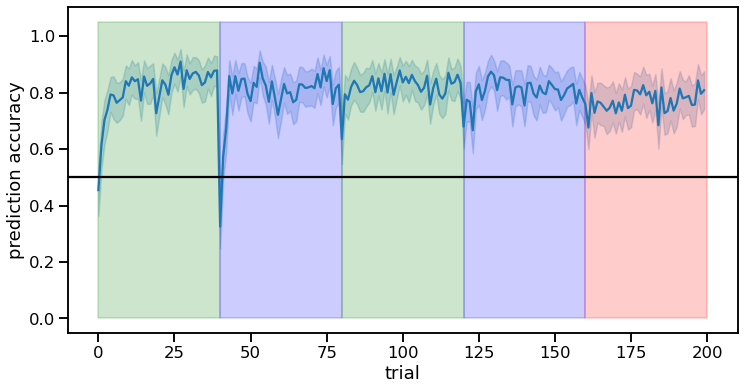

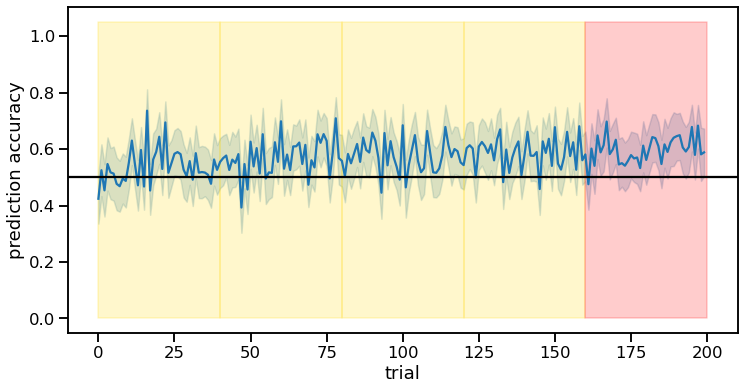

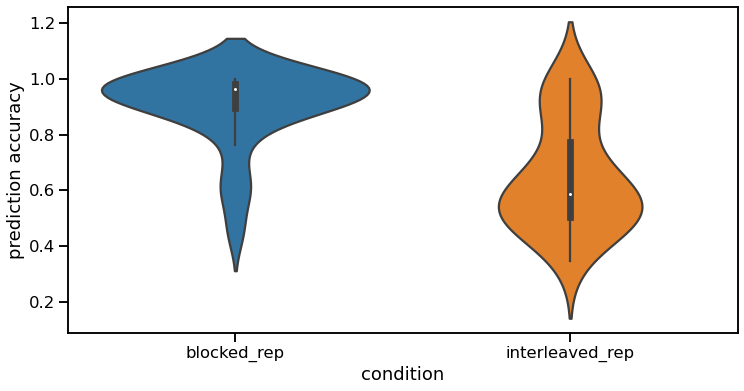

In [9]:
lineplt(['blocked_rep','interleaved_rep'],0.9)
beetestplt(['blocked_rep','interleaved_rep'],0.9)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

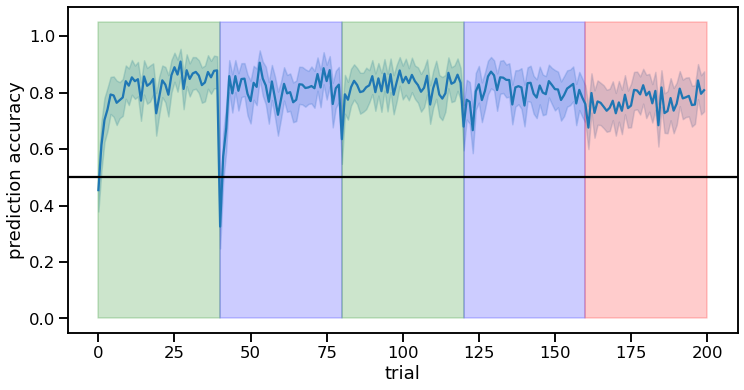

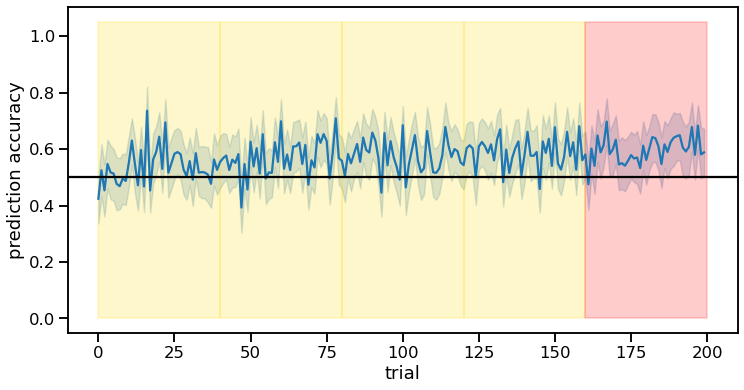

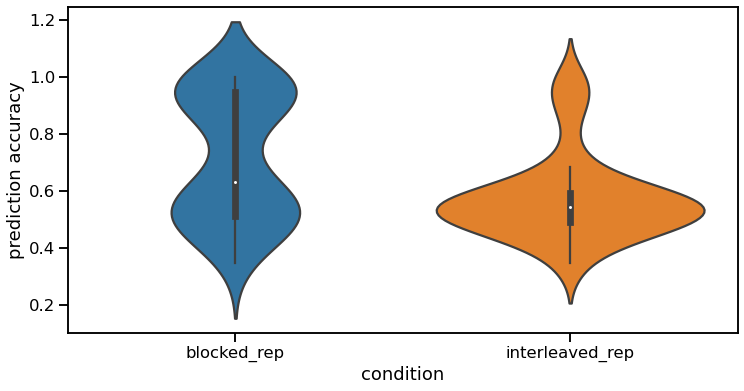

In [62]:
n = 'humanBI'
lineplt(['blocked_rep','interleaved_rep'],0.0,figname=n)
beetestplt(['blocked_rep','interleaved_rep'],0.0,figname=n)

### explicit
- ross 26: human interleaved-explicit performance (should match Fig. 4 in Andre paper)

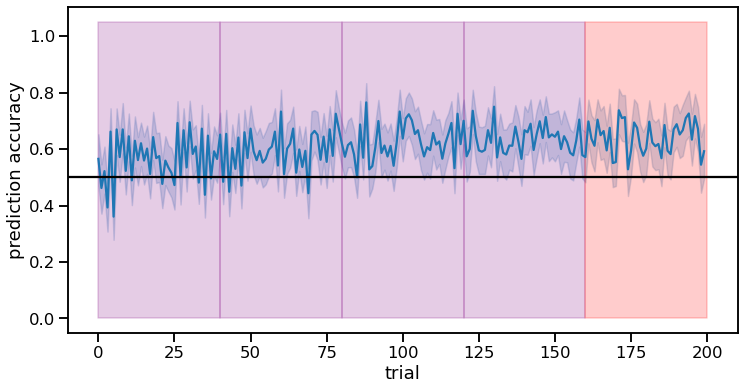

In [63]:
n='explic'
lineplt(['explicit_interleaved'],0.9,figname=n)

## plot transition 2 and 3
- ross 37: human blocked performance (should match upper-left part of Fig. 3 in Andre paper) transition 2 only
- ross 38: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper) transition 2 only
- ross 39: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper) transition 2 only
- ross 40: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper) transition 2 only
- ross 41: human interleaved-explicit performance (should match Fig. 4 in Andre paper) transition 2 only


- ross 48: human blocked performance (should match upper-left part of Fig. 3 in Andre paper) transition 3 only
- ross 49: human interleaved performance (should match upper-right part of Fig. 3 in Andre paper) transition 3 only
- ross 50: human blocked-replication performance (should match lower-left part of Fig. 3 in Andre paper) transition 3 only
- ross 51: human interleaved-replication performance (should match lower-right part of Fig. 3 in Andre paper) transition 3 only
- ross 52: human interleaved-explicit performance (should match Fig. 4 in Andre paper) transition 3 only


##### transition 2

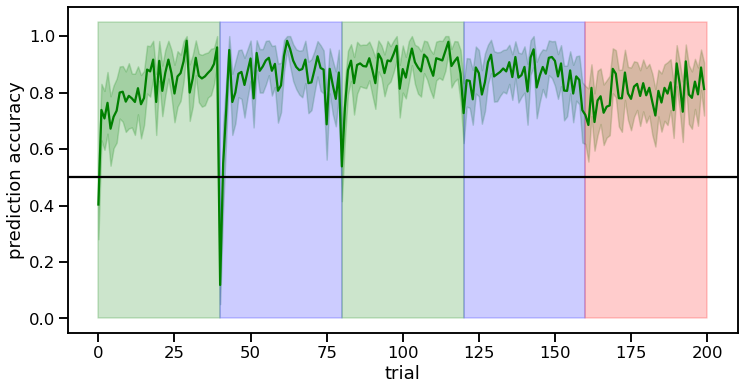

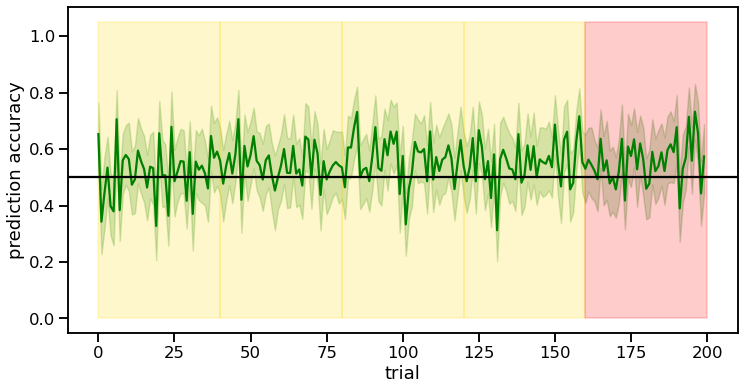

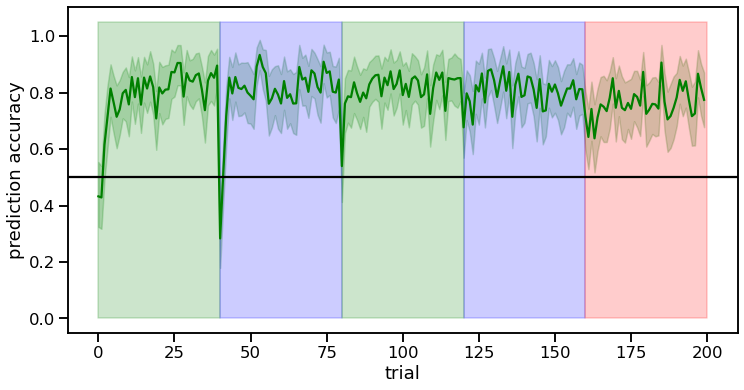

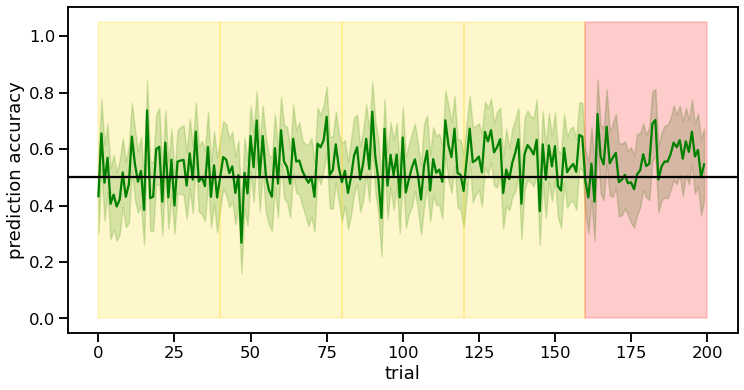

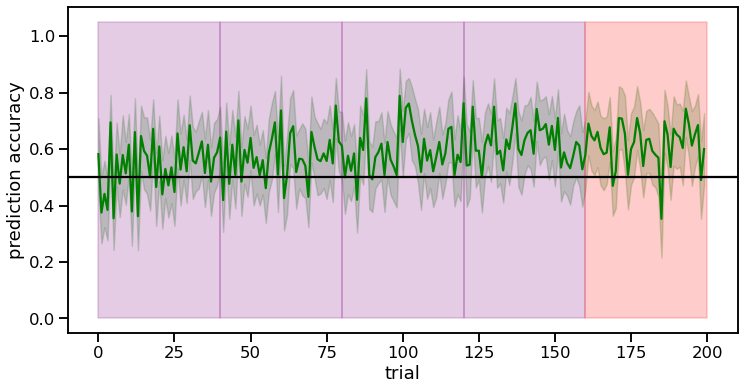

In [12]:
n='trans2'
cL = ["blocked","interleaved","blocked_rep","interleaved_rep","explicit_interleaved"]
lineplt(cL,0.9,transition=1,fgkw={'color':'g'},figname=n)

##### transition 3

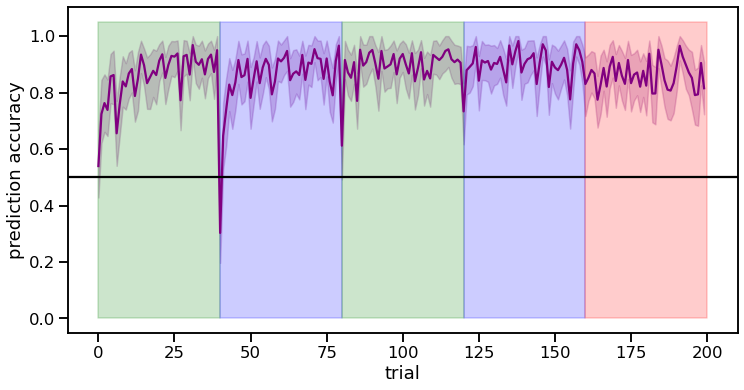

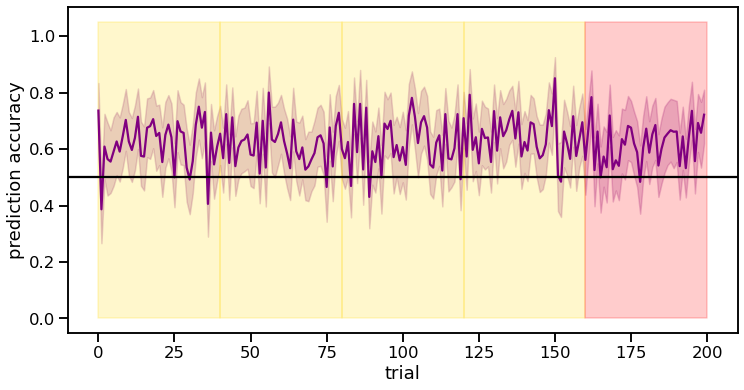

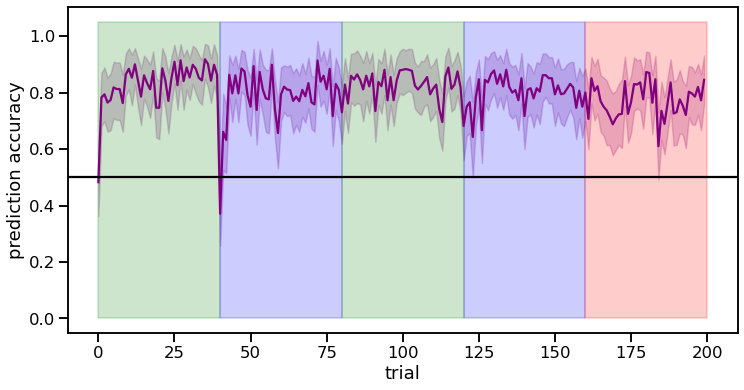

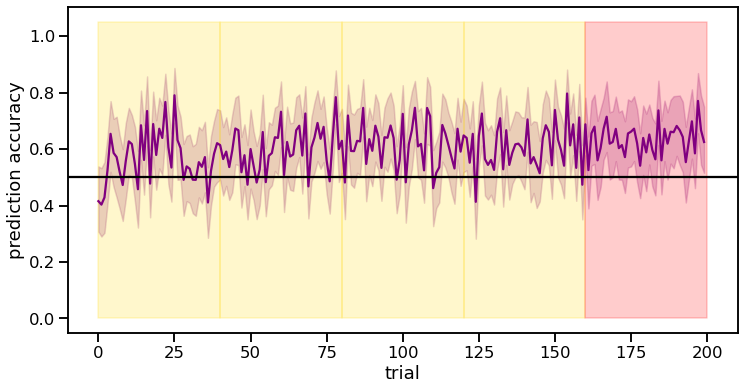

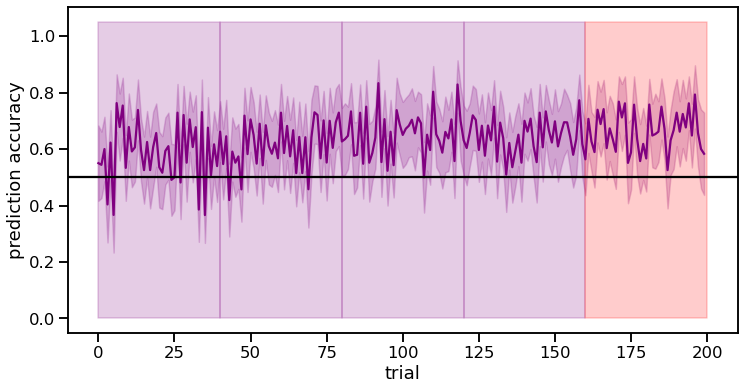

In [13]:
n='trans3'
lineplt(cL,0.9,transition=2,fgkw={'color':'purple'},figname=n)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

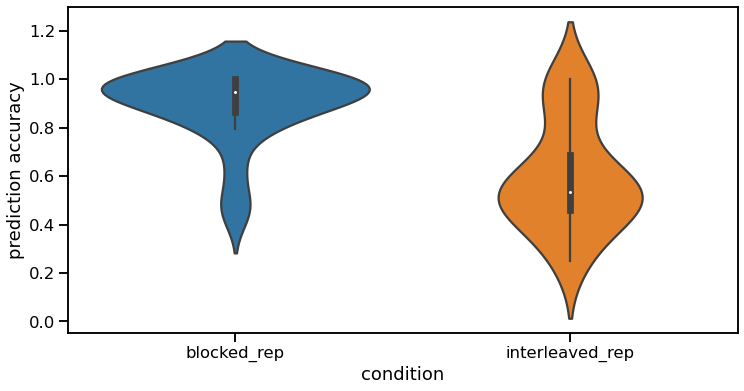

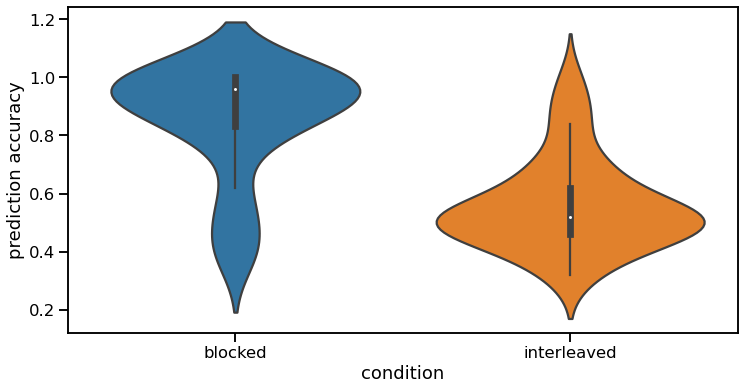

In [14]:
n='trans2'
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=1,figname=n)
beetestplt(['blocked','interleaved'],0.9,transition=1,figname=n)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

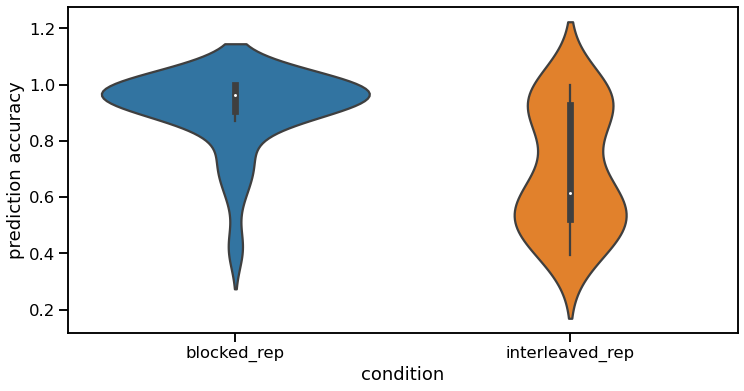

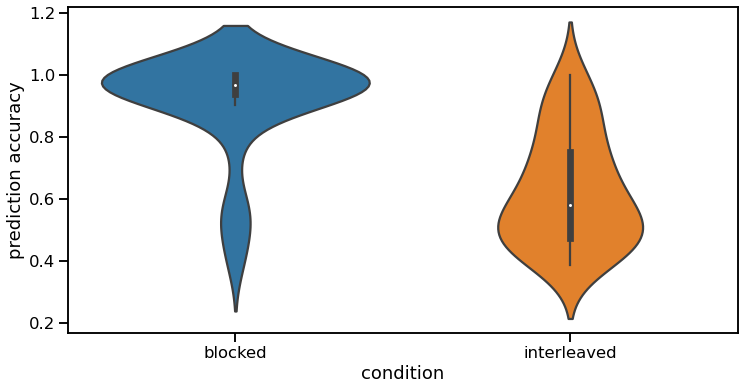

In [15]:
n='trans3'
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=2,figname=n)
beetestplt(['blocked','interleaved'],0.9,transition=2,figname=n)

# modeling

## load model dfs

In [16]:
model_acc_df = pd.read_csv(f"data_csv/model/acc_df.csv")
model_states_df = pd.read_csv("data_csv/model/states_df.csv")
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## plotting functions

In [17]:
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])

In [18]:
def lineplot_model(gsname,condstr,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
#   color_background(ax,condstr)
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)
  return ax
  
def lineplot_modelBI(gsname,ax=None):
  for ix in [0,1]:
#     ax=axar[ix]
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['blocked','interleaved'][ix])
    plt.savefig(fig_save_path+'png/model/BI%i-lineplt-%s.png'%(ix,gsname))
    plt.savefig(fig_save_path+'svg/model/BI%i-lineplt-%s.svg'%(ix,gsname))
  
def lineplot_modelEML(gsname):
  for ix in [2,3,4]:
#     ax=axar[ix-2]
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['early','middle','late'][ix-2])
    plt.savefig(fig_save_path+'png/model/EML%i-lineplt-%s.png'%(ix,gsname))
    plt.savefig(fig_save_path+'svg/model/EML%i-lineplt-%s.svg'%(ix,gsname))

In [19]:
def beeswarm_model(gsname,condstr,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('condition')
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)

def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond_int<2')
  plt.savefig(fig_save_path+'png/model/BI-violin-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/BI-violin-%s.svg'%(gsname))
  
def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond_int>=2')
  plt.savefig(fig_save_path+'png/model/EML-violin-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/EML-violin-%s.svg'%(gsname))


In [20]:
def scatter_adjrand_vs_acc(gsname,ax=None,tstep=[1,2]):
  if not ax:
    plt.figure()
    ax=plt.gca()
  for six in range(100):
    q = f"seed=={six} & gs=='{gsname}'& cond_int==1 & trial>=160"
    sdf_states = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean()
    adjrand = adjusted_rand_score(
      sdf_states.query('tstep==%i'%tstep[0]).exp,
      sdf_states.query('tstep==%i'%tstep[1]).xth
    )
    ax.scatter(adjrand,sacc,c='k')
  ax.set_xlabel('adjusted rand')
  ax.set_ylabel('acc')
  ax.set_title(gsname)
  plt.savefig(fig_save_path+'png/model/scatter_adjrand_vs_acc-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/scatter_adjrand_vs_acc-%s.svg'%(gsname))
  


In [21]:
# def inspect_adjrand_vs_acc(gsname,ax=None,tstep=[1,2]):
#   L = []
#   for six in range(100):
#     q = f"seed=={six} & gs=='{gsname}'& cond_int==1 & trial>=160"
#     sdf_states = model_states_df.query(q)
#     sacc = model_acc_df.query(q).acc.mean()
#     adjrand = adjusted_rand_score(
#       sdf_states.query('tstep==1').exp,
#       sdf_states.query('tstep==2').xth
#     )
#     if adjrand<0.2 and sacc<0.5:
#       L.append(sdf_states)
#   return L


# L = inspect_adjrand_vs_acc(V2,ax=None,tstep=[1,2])

In [22]:
# for s in range(10):
#   xth = L[s].xth.values.reshape(40,-1)
#   exp = L[s].exp.values.reshape(40,-1)
#   print()
#   print('SEED = ',s)
#   print()
#   for i in range(40):
#     print()
#     print("observation= ",exp[i])
#     print("prediction    = ",xth[i])


# version 5: skipt1 = false; no variability across seeds 
- ross 9: model version 5 (skipt1=false, no var across seeds) blocked performance
- ross 10: model version 5 (skipt1=false, no var across seeds) interleaved performance 
- ross 11: model version 5 (skipt1=false, no var across seeds) beeswarm plot of blocked and interleaved test accuracy (each dot is a seed; separate “beeswarms” for each condition)


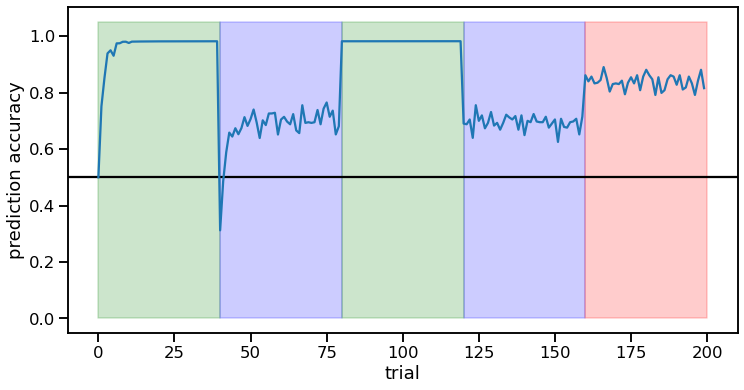

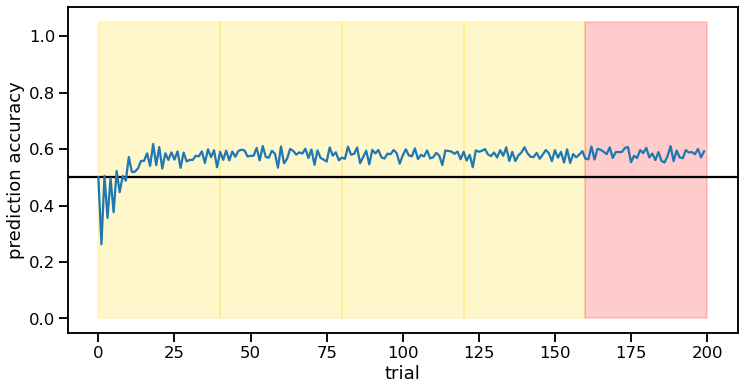

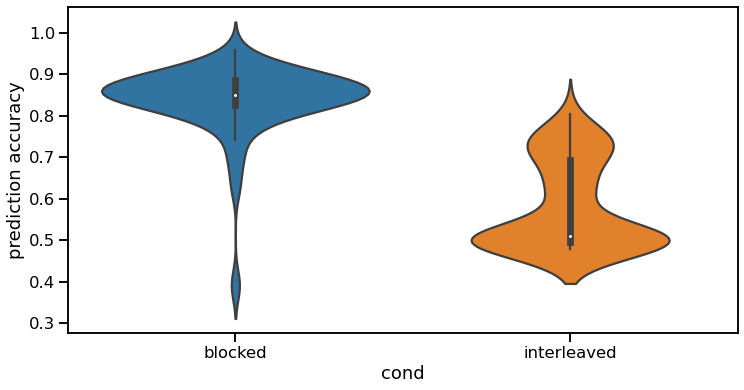

In [23]:
gsname = V5
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# version 1: skipt1 = true; no variability across seeds
- ross 12: blocked performance
- ross 13: interleaved performance 
- ross 14: beeswarm plot of blocked and interleaved test accuracy 
- ross 15: scatterplot of “new adjusted rand” vs. test accuracy in the interleaved condition (each dot is a seed) (“new adjusted rand” tracks whether the model tends to respond with the same 5 vs. 6 state depending on whether the actual state is 1 vs. 2)

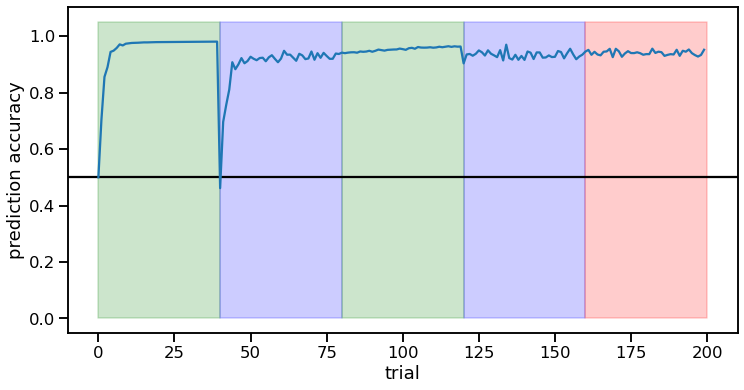

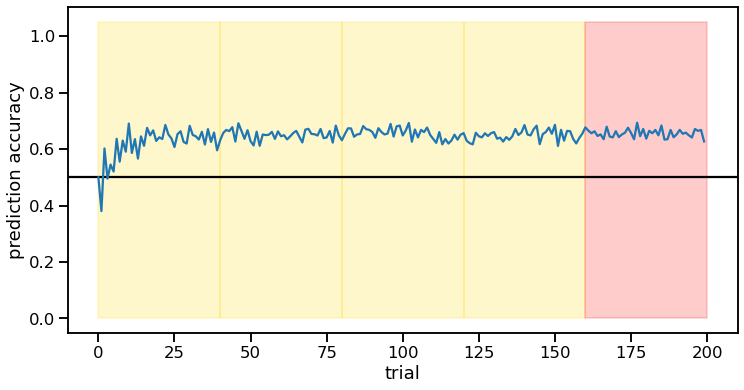

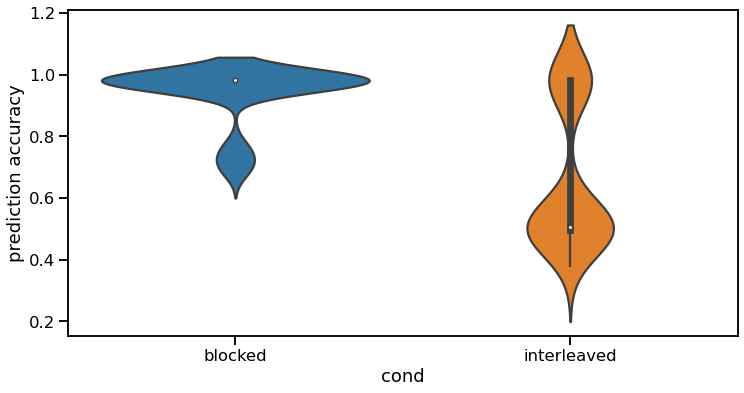

In [24]:
gsname = 'gs0317'
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

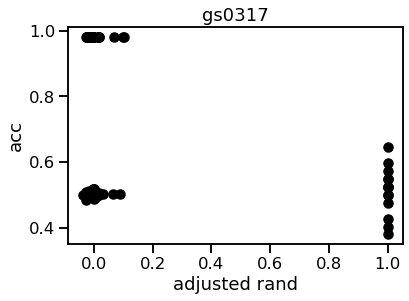

In [25]:
scatter_adjrand_vs_acc(V1)


### human adjusted rand vs testacc
- ross 16: human interleaved data scatterplot of “new adjusted rand” vs. test accuracy (each dot is a participant)

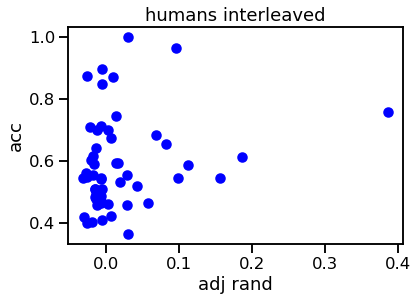

In [26]:
ax=plt.gca()
for six,sdf in human_df.query("condition=='interleaved' & story>=160").groupby('subjnum'):
  acc = sdf.correct_response.mean()
  sdf_ = sdf.query("depth==1")
  adjrand = adjusted_rand_score(sdf_.response_node_int,sdf_.rfc_int)
  ax.scatter(adjrand,acc,c='b')
ax.set_xlabel('adj rand')
ax.set_ylabel('acc')
ax.set_title('humans interleaved')
plt.savefig(fig_save_path+'png/human/scatter_adjrand_vs_acc.png')
plt.savefig(fig_save_path+'svg/human/scatter_adjrand_vs_acc.svg')

#### TODO: scatter yoked sequence seed acc to human acc. see ross version 8 (plots 59,60)
- there may also be a benefit to making a scatterplot of actual accuracy vs. predicted accuracy in the interleaved (and interleaved replication) condition for “sequence matched” model seeds and participants – we expect that the r value for this scatterplot should be close to zero; note that ross did this for gridsearch version 8 (see ross plots 59, 60) – you should be able to leverage this code to re-do the analysis for gridsearch version 1

 no rep pid_acc_list:  39
rep pid_acc_list:  63


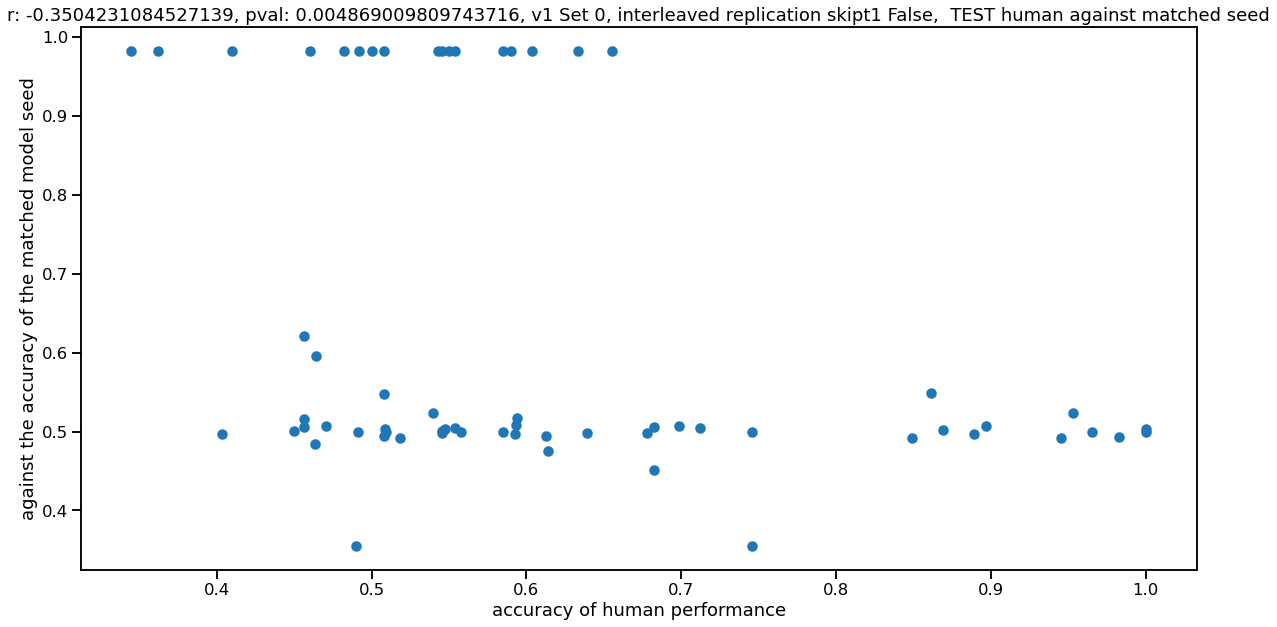

In [27]:
# get the scatter plots 
gsname = 'gs0317'
# gsdf = pd.read_csv('/Volumes/norman/rkempner/interleaved_blocked_modeling/data/gs0317_version8_skipt1False_except_blocked/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf = pd.read_csv('~/wd/csw/interleaved_blocked_modeling/data/all_csv/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf.loc[:,"mse-bi"] = gsdf.b_mse1+gsdf.b_mse2+gsdf.i_mse1+gsdf.i_mse2
TOP_K = 1
## select top40 MSE
topKgsdf = gsdf.sort_values('mse-bi').iloc[:TOP_K]
## LOOP
for rank,(idx,row) in enumerate(topKgsdf.iterrows()):
  param_set_num = rank
  args,paramstr = get_argsD(row)

  # INTERLEAVED
  participant_to_exp_path = "versionX_interleaved_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials

  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleaved_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print(" no rep pid_acc_list: ", len(pid_acc_list))
  
  # FIGURE MAKING
#   plt.figure(figsize=(20,10))
#   plt.scatter(pid_acc_list,matched_seed_acc_list)
#   plt.xlabel("accuracy of human performance")
#   plt.ylabel("against the accuracy of the matched model seed")
#   r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
#   plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved skipt1 False,  TEST human performance against model seed")
#   plt.show()
#   plt.savefig(fig_save_path+'png/human/scatter_yoked_model_seq.png')
#   plt.savefig(fig_save_path+'svg/human/scatter_yoked_model_seq.svg')

  # interleaved rep
  participant_to_exp_path = "versionX_interleavedRep_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials

  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleavedRep_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
#   pid_acc_list = []
#   matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print("rep pid_acc_list: ", len(pid_acc_list))
#   plt.clf()
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved replication skipt1 False,  TEST human against matched seed")
#   plt.show()
  
  plt.savefig(fig_save_path+'png/human/scatter_yoked_model_seq-BOTH.png')
  plt.savefig(fig_save_path+'svg/human/scatter_yoked_model_seq-BOTH.svg')



 no rep pid_acc_list:  39
rep pid_acc_list:  24


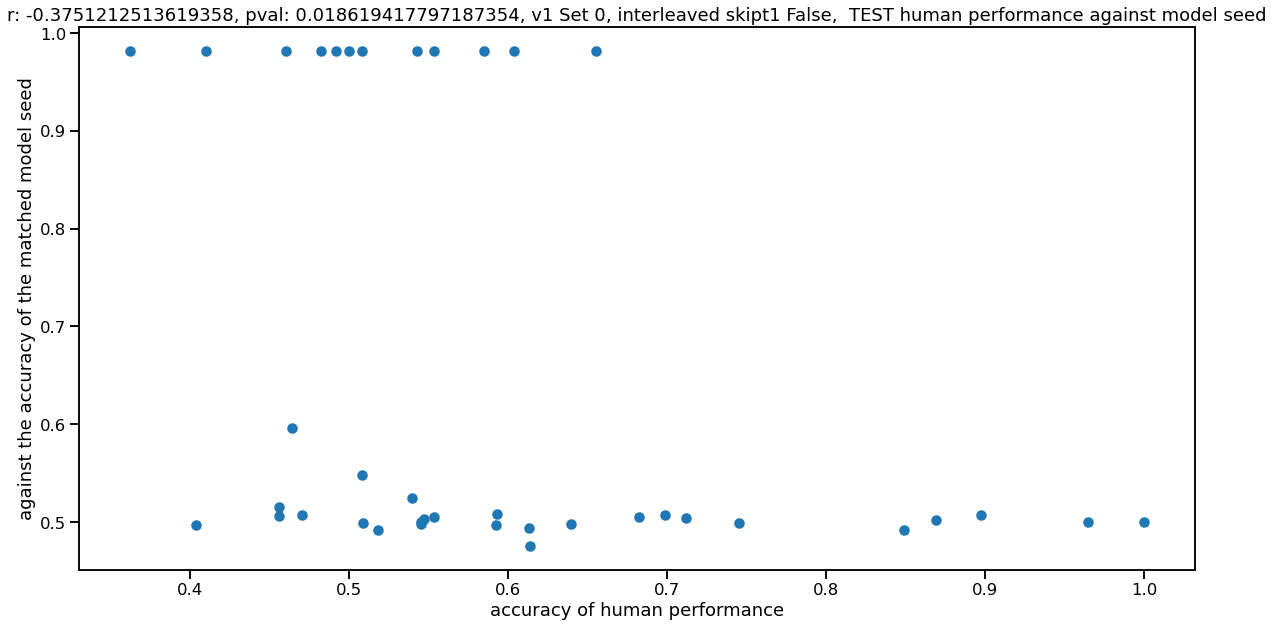

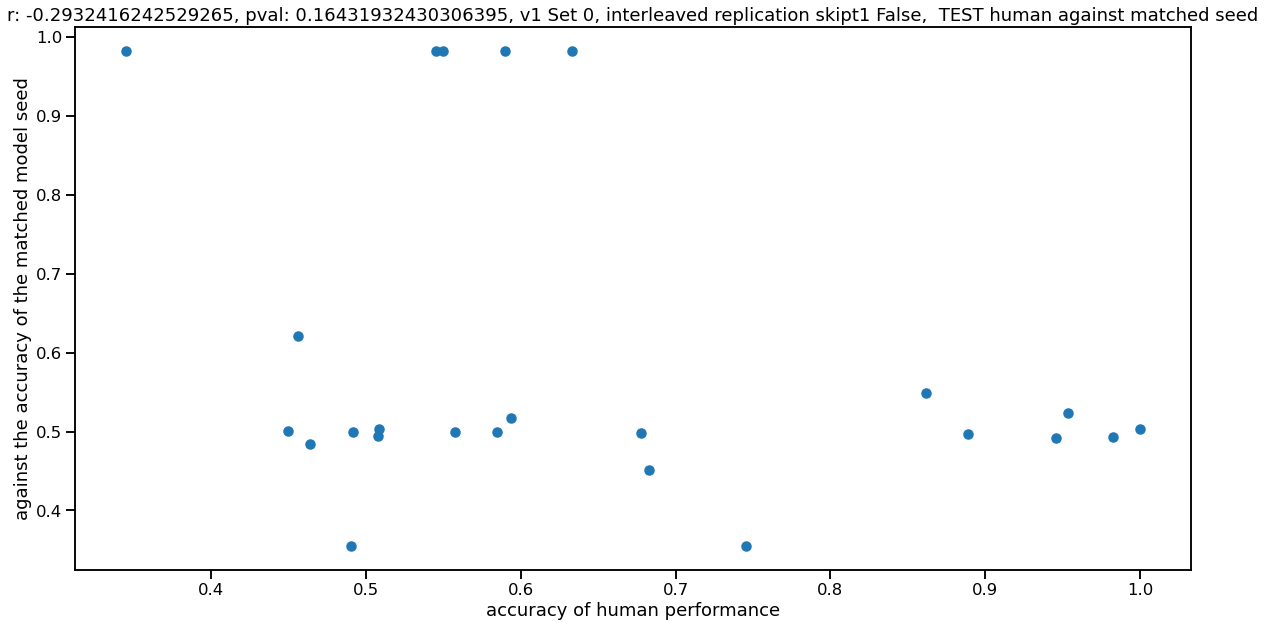

In [28]:
# get the scatter plots 
gsname = 'gs0317'
# gsdf = pd.read_csv('/Volumes/norman/rkempner/interleaved_blocked_modeling/data/gs0317_version8_skipt1False_except_blocked/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf = pd.read_csv('~/wd/csw/interleaved_blocked_modeling/data/all_csv/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf.loc[:,"mse-bi"] = gsdf.b_mse1+gsdf.b_mse2+gsdf.i_mse1+gsdf.i_mse2
TOP_K = 1
## select top40 MSE
topKgsdf = gsdf.sort_values('mse-bi').iloc[:TOP_K]
## LOOP
for rank,(idx,row) in enumerate(topKgsdf.iterrows()):
  param_set_num = rank
  args,paramstr = get_argsD(row)

  # INTERLEAVED
  participant_to_exp_path = "versionX_interleaved_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials

  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleaved_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print(" no rep pid_acc_list: ", len(pid_acc_list))
  
  # FIGURE MAKING
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved skipt1 False,  TEST human performance against model seed")
#   plt.show()
  plt.savefig(fig_save_path+'png/human/scatter_yoked_model_seq.png')
  plt.savefig(fig_save_path+'svg/human/scatter_yoked_model_seq.svg')

  # interleaved rep
  participant_to_exp_path = "versionX_interleavedRep_participant_to_exp.pickle"
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials

  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = "versionX_interleavedRep_participant_to_testAcc.pickle"
  with open(participant_to_testAcc_path, 'rb') as pickle_file:
    participant_to_testAcc = pickle.load(pickle_file)
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print("rep pid_acc_list: ", len(pid_acc_list))
#   plt.clf()
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved replication skipt1 False,  TEST human against matched seed")
#   plt.show()
  
  plt.savefig(fig_save_path+'png/human/scatter_yoked_model_seq-rep.png')
  plt.savefig(fig_save_path+'svg/human/scatter_yoked_model_seq-rep.svg')



# version 2: skipt1 = true; variable concentration across seeds 
- ross 17: blocked performance
- ross 18: interleaved performance
- ross 19: beeswarm plot of blocked and interleaved test accuracy 
- ross 20: scatterplot of test accuracy vs. #-of-latent-causes (each dot is a seed) for the interleaved condition
- ross 21: scatterplot of concentration vs. #-of-latent-causes (each dot is a seed) for the interleaved condition


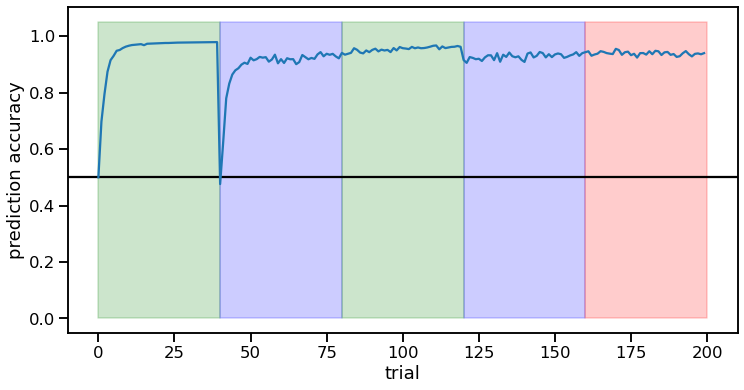

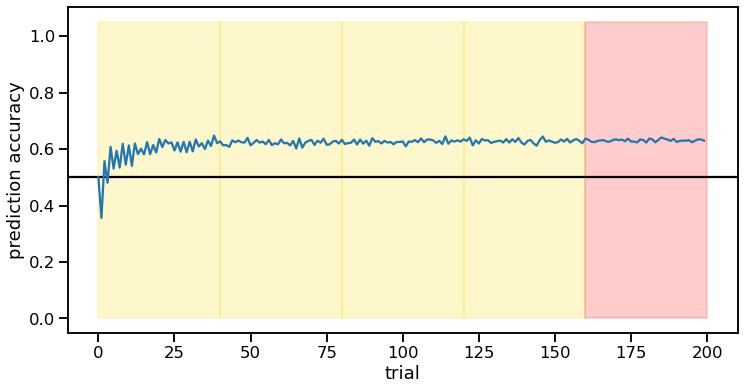

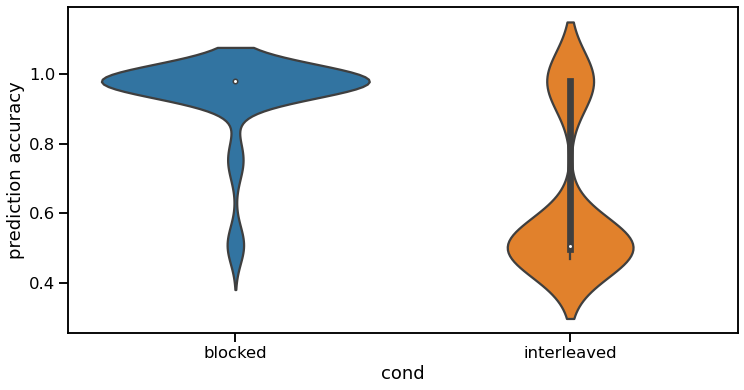

In [29]:
gsname=V2
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

In [50]:
def scatter_numlc_vs_acc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  cond = 1
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"
    seed_states_df = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    nlc = seed_states_df.zt.max()+1
    ax.scatter(nlc,sacc,c='k')
  ax.set_ylabel('test accuracy')
  ax.set_xlabel('number of latent causes')
  if TITLES_ON:
    ax.set_title(gsname)
  plt.savefig(fig_save_path+'png/model/scatter_numlc_vs_acc-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/scatter_numlc_vs_acc-%s.svg'%(gsname))
  
def scatter_concentration_vs_numlc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  q = f"gs=='{gsname}'&cond==1"
  for six,sdf in model_states_df.query(q).groupby('seed'):
    numlc=sdf.zt.max()
    ax.scatter(sdf.alpha.unique(),numlc+1,c='k')
  ax.set_xlabel('concentration')
  ax.set_ylabel('number of latent causes')
  if TITLES_ON:
    ax.set_title(gsname)
  plt.savefig(fig_save_path+'png/model/scatter_alpha_vs_numlc-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/scatter_alpha_vs_numlc-%s.svg'%(gsname))
  
def scatter_concentration_vs_acc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  cond=1
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"
    seed_states_df = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    alpha = model_states_df.query(q).alpha.unique()[0]
    ax.scatter(alpha,sacc,c='k')
  ax.set_xlabel('concentration')
  ax.set_ylabel('test accuracy')
  if TITLES_ON:
    ax.set_title(gsname)
  plt.savefig(fig_save_path+'png/model/scatter_alpha_vs_acc-%s.png'%(gsname))
  plt.savefig(fig_save_path+'svg/model/scatter_alpha_vs_acc-%s.svg'%(gsname))
  return None

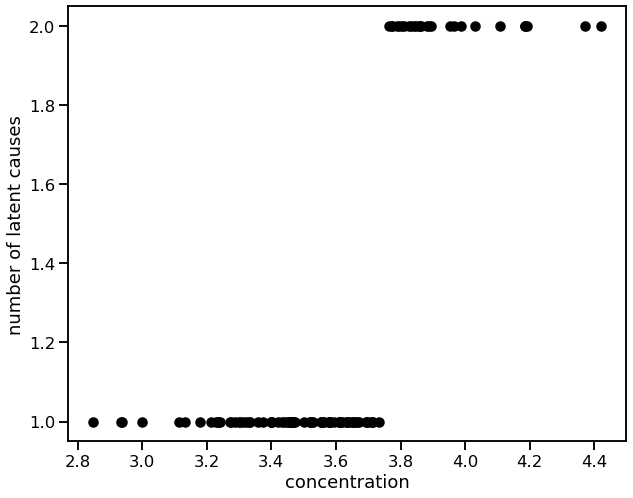

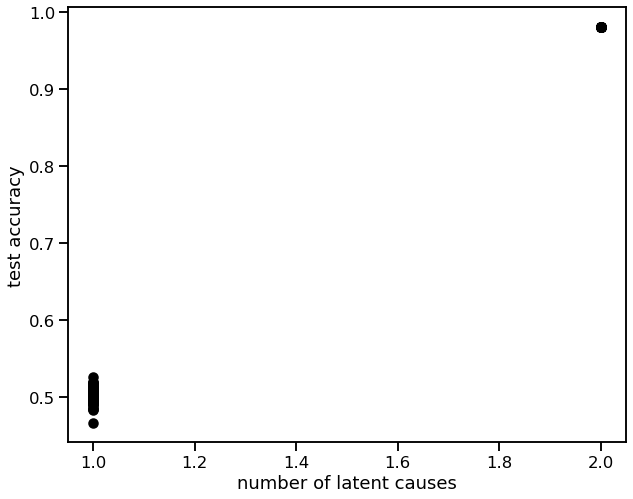

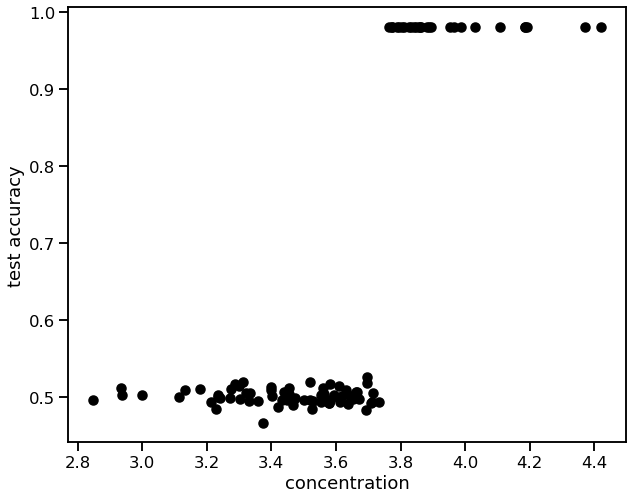

In [51]:
scatter_concentration_vs_numlc(V2)
scatter_numlc_vs_acc(V2)
scatter_concentration_vs_acc(V2)

# version 9: skipt1 = true starting in 2nd block for blocked, always false for interleaved; variable concentration across seeds
ross 64: model version 9, parameter set 0, blocked performance

ross 65: model version 9, parameter set 0, interleaved performance

ross 66: model version 9, parameter set 0, beeswarm plot of blocked and interleaved test accuracy (each dot is a seed; separate “beeswarms” for each condition)

ross 67: model version 9, parameter set 0, scatterplot of test accuracy vs. #-of-latent-causes (each dot is a seed) for the interleaved condition (same as plot 20 except for model version 9)

ross 68: model version 9, parameter set 0, scatterplot of concentration vs. #-of-latent-causes (each dot is a seed) for the interleaved condition (same as plot 21 except for model version 9)


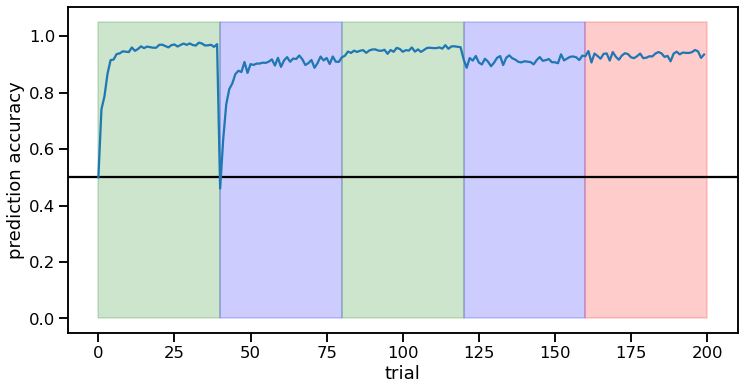

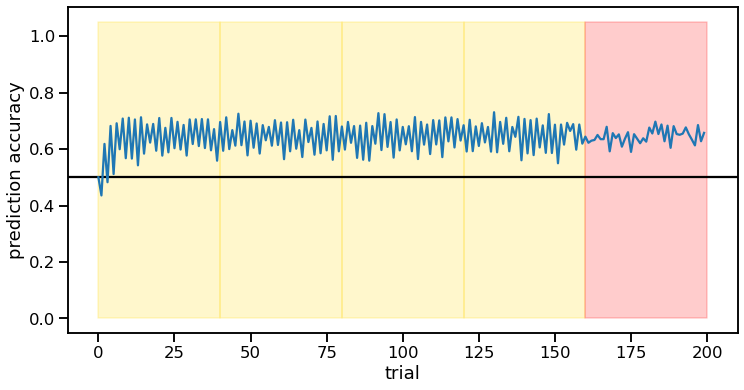

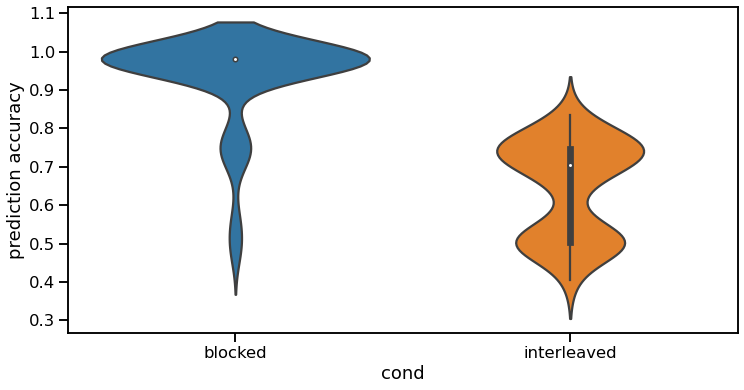

In [32]:
lineplot_modelBI(V9)
beeswarm_modelBI(V9)

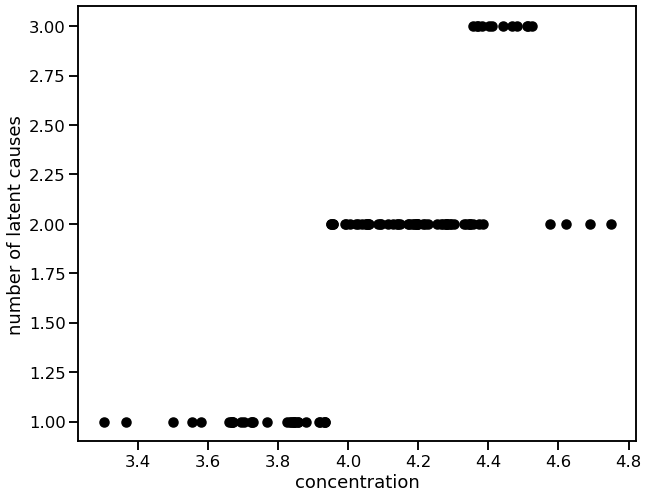

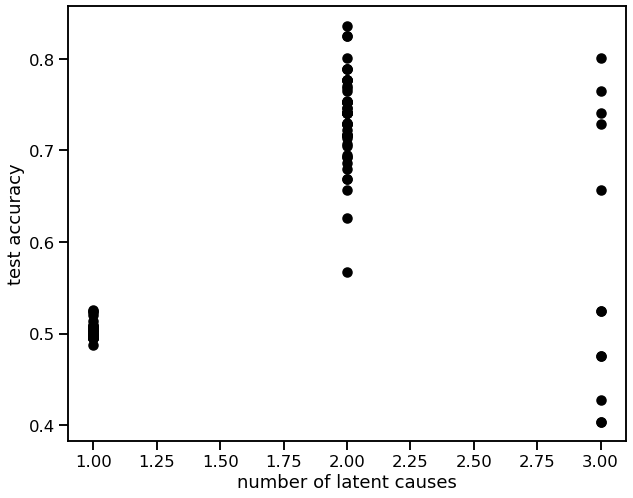

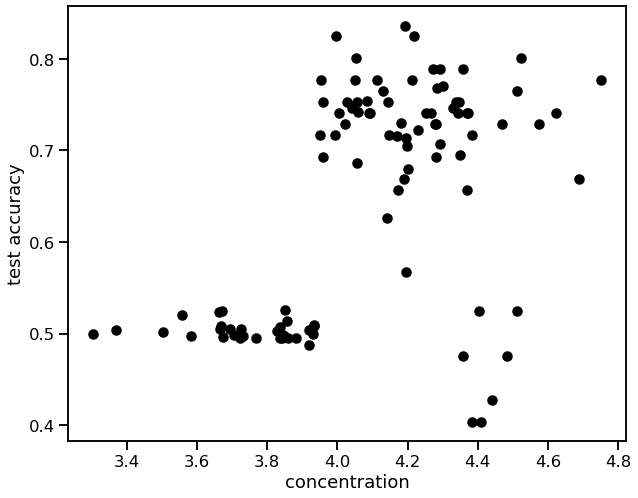

In [52]:
# fg,axar = plt.subplots(1,3,figsize=(20,5))
scatter_concentration_vs_numlc(V9)
scatter_numlc_vs_acc(V9)
scatter_concentration_vs_acc(V9)

## version 9: EML predictions
- ross 69: model version 9, parameter set 0, early performance (same as plot 22 except for model version 9)
- ross 70: model version 9, parameter set 0, middle performance (same as plot 23 except for model version 9)
- ross 71: model version 9, parameter set 0, late performance (same as plot 24 except for model version 9)
- ross 72: model version 9, parameter set 0, beeswarm plot of early, middle, late test accuracy (each dot is a seed; separate “beeswarms” for each condition) (same as plot 25 except for model version 9)


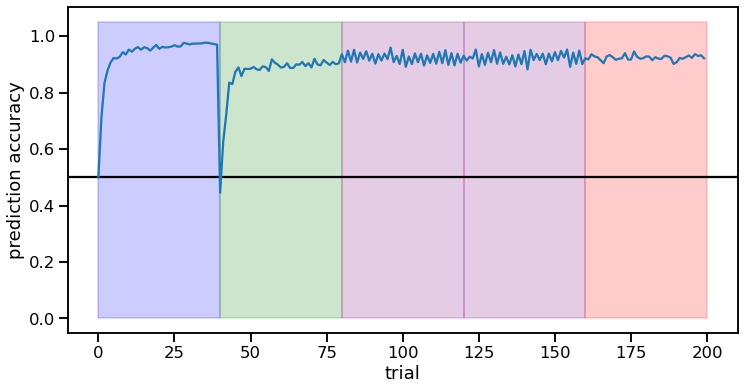

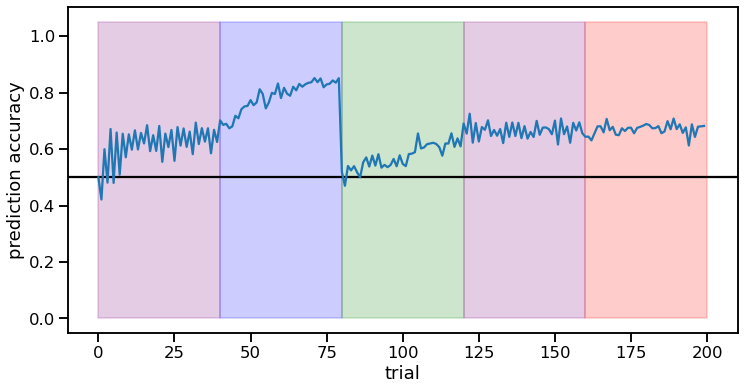

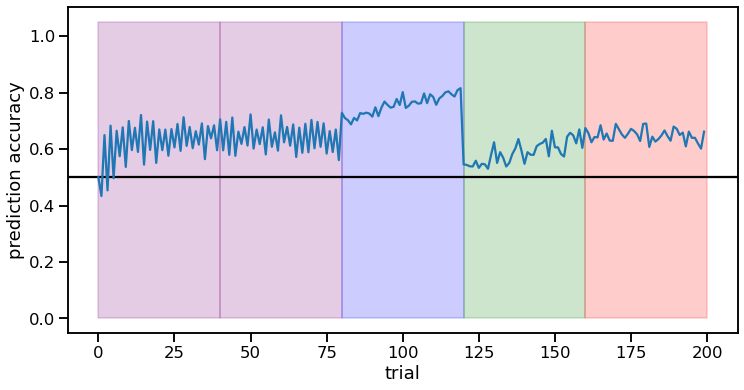

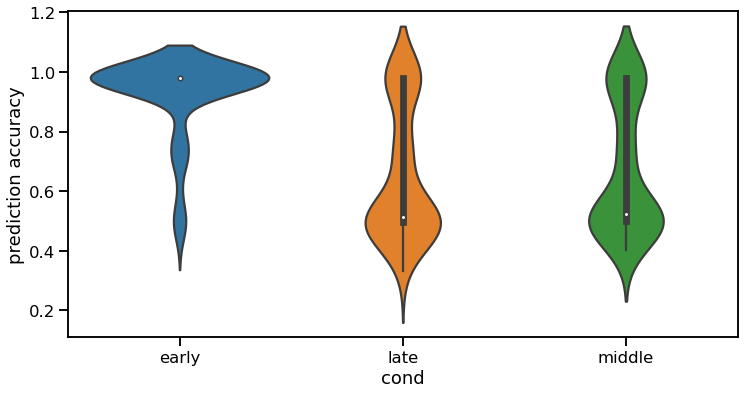

In [34]:
gsname=V9
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)

# version 2: EML predictions

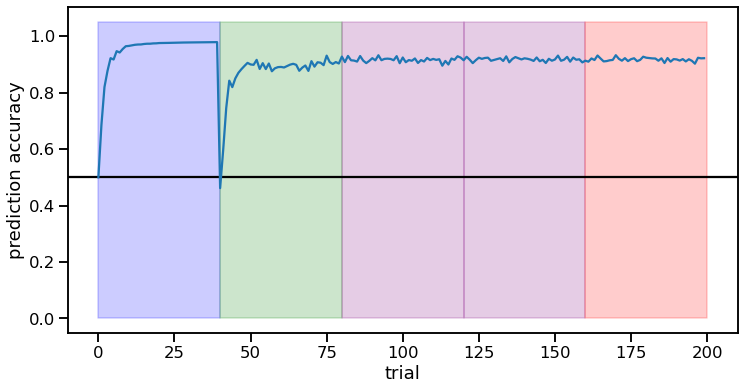

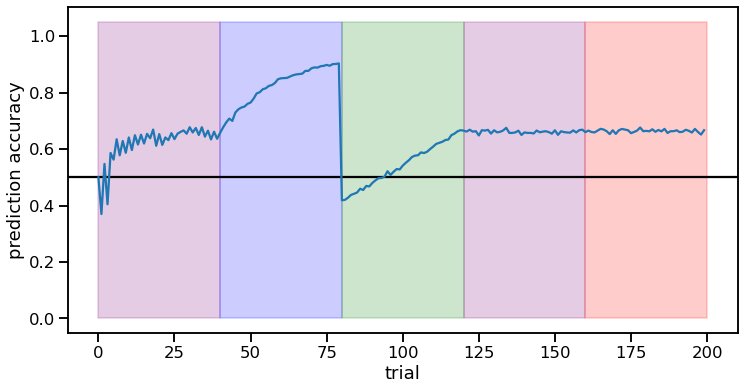

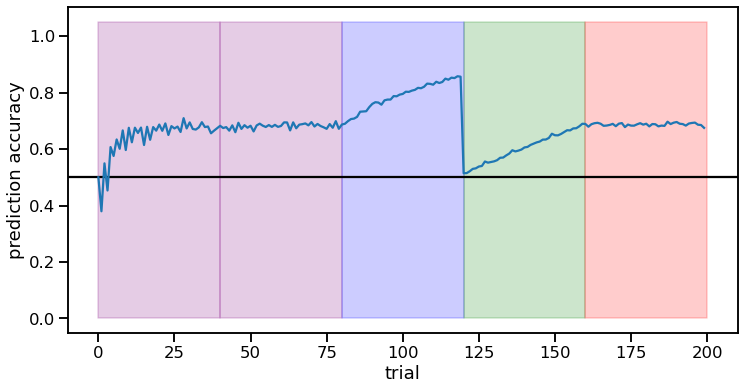

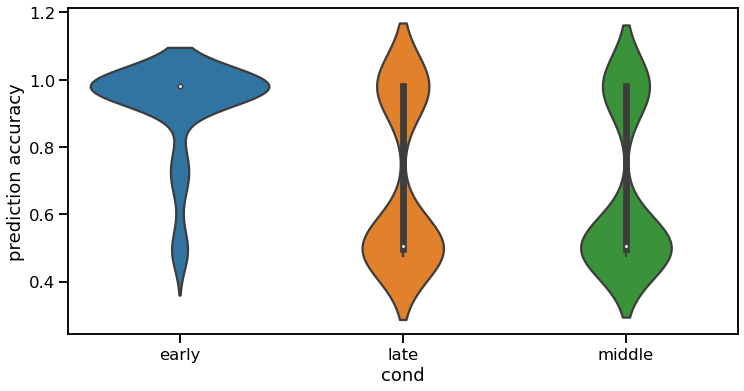

In [35]:
gsname=V2
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)

# human EML
ross 27: human early performance (should match top-left part of Fig. 8 in Andre paper)

ross 28: human middle performance (should match middle-left part of Fig. 8 in Andre paper)

ross 29: human late performance (should match bottom-left part of Fig. 8 in Andre paper)

ross 30: beeswarm plot of human early, middle, late test accuracy (each dot is a participant; separate “beeswarms” for each condition)

ross 31: beeswarm plot of human early, middle, late test accuracy including all participants (not just the “90% filtered” participants)

ross 32: human early-replication performance (should match top-right part of Fig. 8 in Andre paper)

ross 33: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper)

ross 34: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper)

ross 35: beeswarm plot of early-replication, middle-replication, late-replication test accuracy (each dot is a participant; separate “beeswarms” for each condition)

ross 36: beeswarm plot of early-replication, middle-replication, late-replication test accuracy including all participants (not just the “90% filtered” participants)


In [36]:
human_df.condition.unique()

array(['blocked', 'interleaved', 'blocked_rep', 'interleaved_rep',
       'explicit_interleaved', 'inserted_early', 'inserted_middle',
       'inserted_late', 'inserted_early_rep', 'inserted_middle_rep',
       'inserted_late_rep'], dtype=object)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

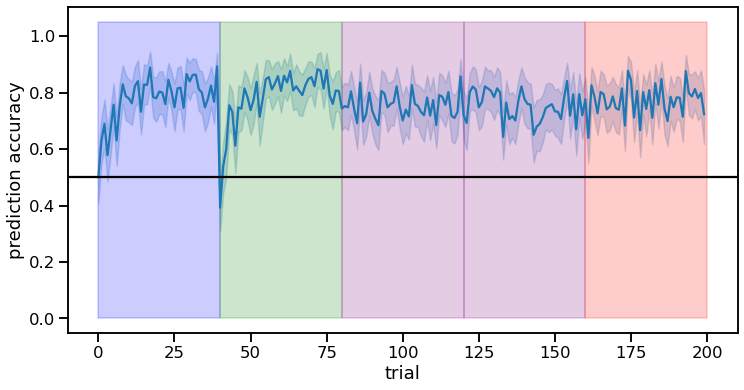

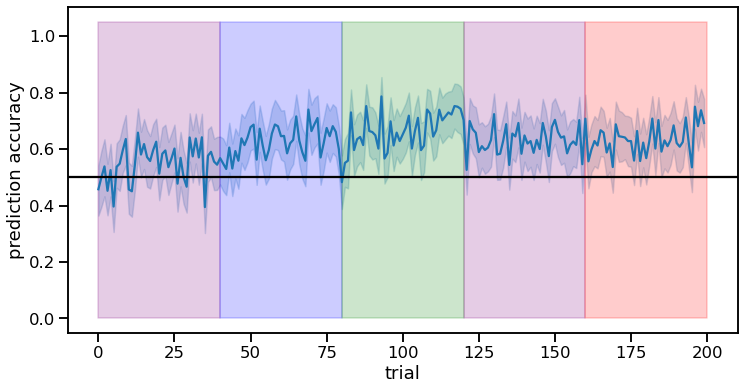

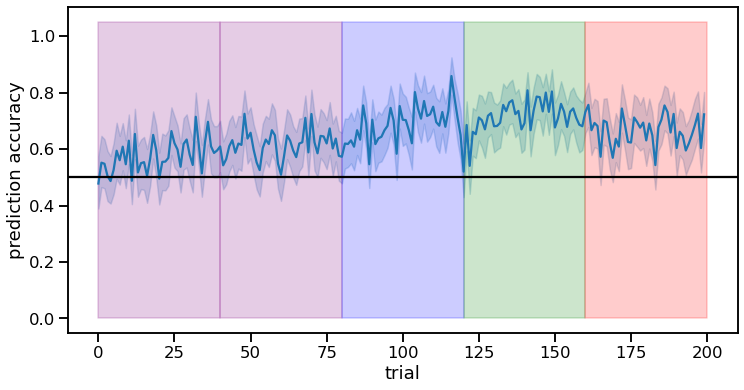

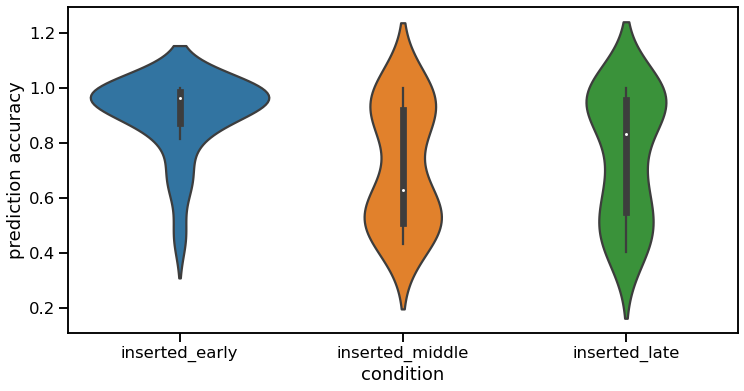

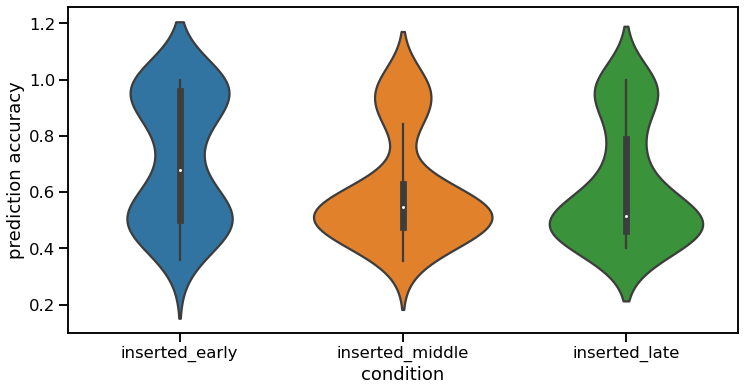

In [37]:
condL = ['inserted_early','inserted_middle','inserted_late']
lineplt(condL,0.9)
beetestplt(condL,0.9)
beetestplt(condL,0.0)

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

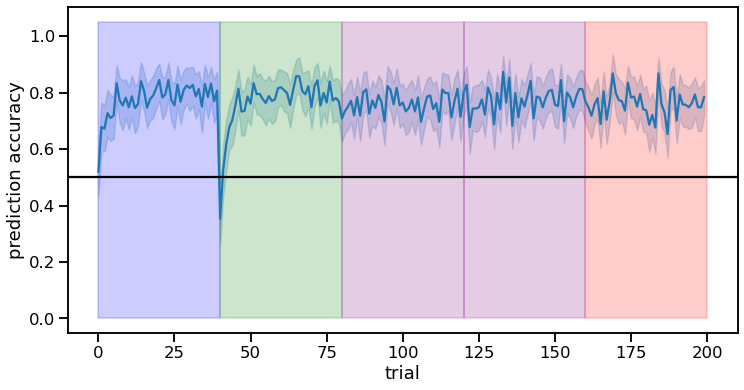

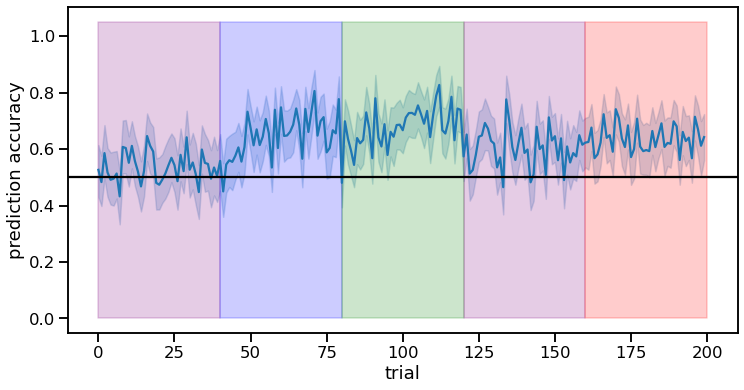

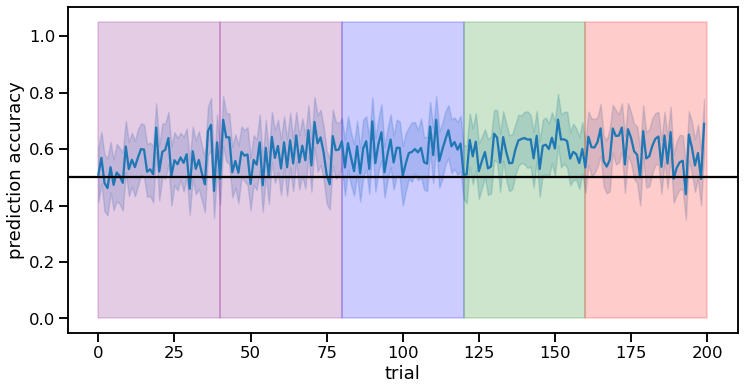

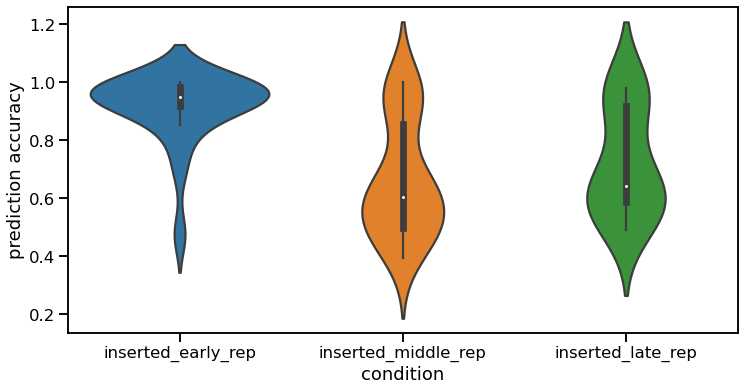

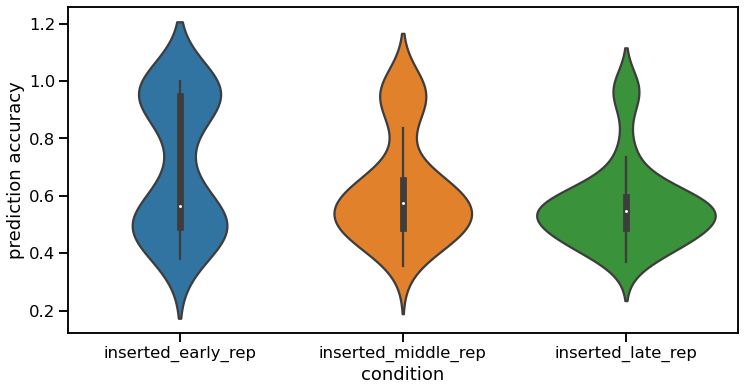

In [38]:
condL = ['inserted_early_rep','inserted_middle_rep','inserted_late_rep']
lineplt(condL,0.9)
beetestplt(condL,0.9)
beetestplt(condL,0.0)

- ross 42: human early performance (should match top-left part of Fig. 8 in Andre paper) transition 2 only
- ross 43: human middle performance (should match middle-left part of Fig. 8 in Andre paper) transition 2 only
- ross 44: human late performance (should match bottom-left part of Fig. 8 in Andre paper) transition 2 only
- ross 45: human early-replication performance (should match top-right part of Fig. 8 in Andre paper) transition 2 only
- ross 46: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper) transition 2 only
- ross 47: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper) transition 2 only
- ross 53: human early performmance (should match top-left part of Fig. 8 in Andre paper) transition 3 only
- ross 54: human middle performance (should match middle-left part of Fig. 8 in Andre paper) transition 3 only
- ross 55: human late performance (should match bottom-left part of Fig. 8 in Andre paper) transition 3 only
- ross 56: human early-replication performance (should match top-right part of Fig. 8 in Andre paper) transition 3 only
- ross 57: human middle-replication performance (should match middle-right part of Fig. 8 in Andre paper) transition 3 only
- ross 58: human late-replication performance (should match bottom-right part of Fig. 8 in Andre paper) transition 3 only


##### transition 2

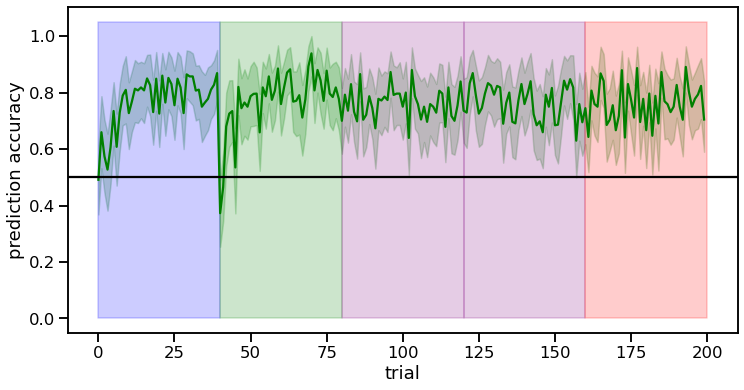

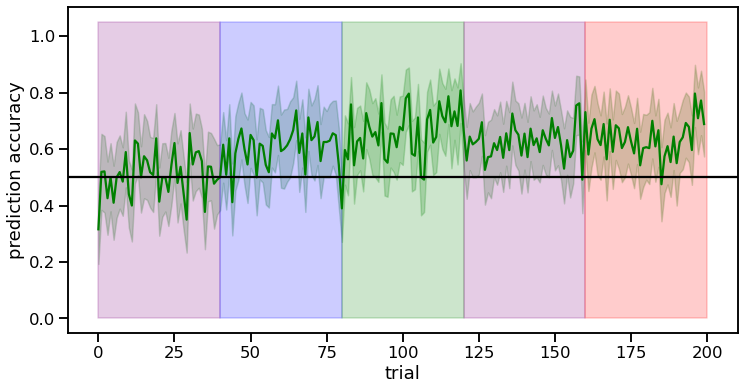

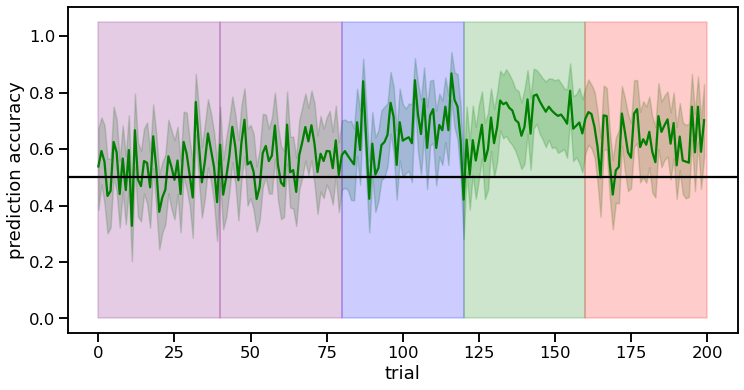

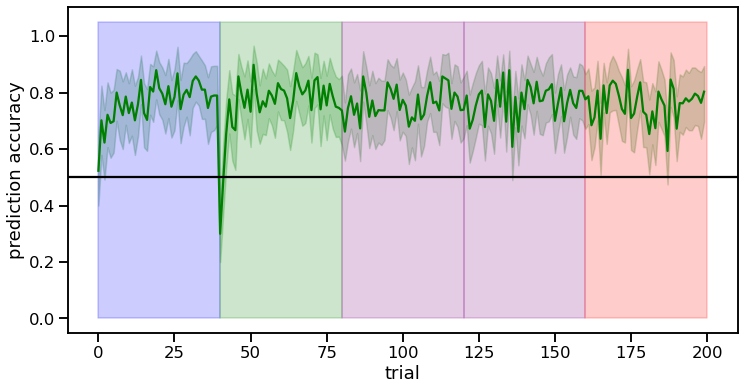

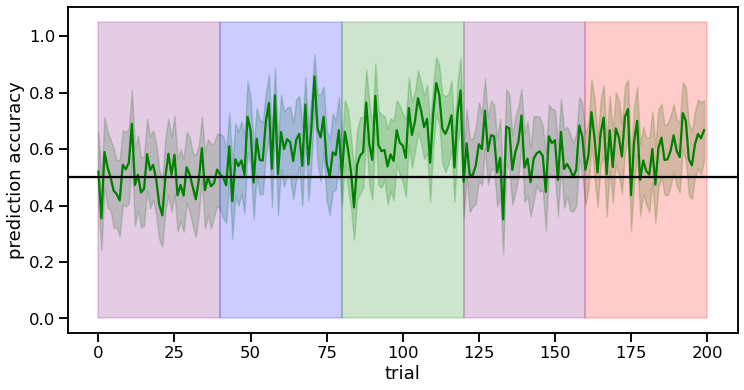

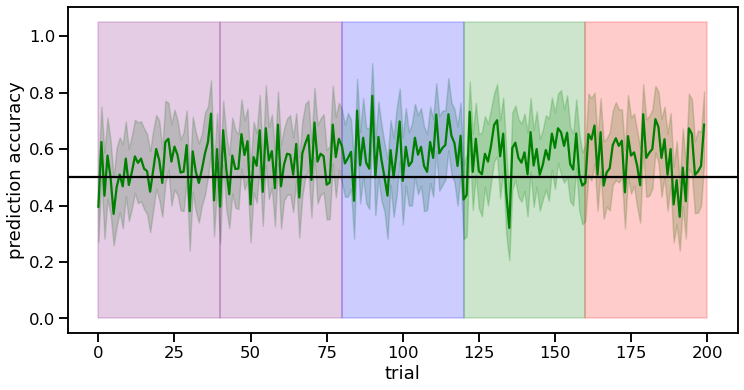

In [39]:
cL = [
  'inserted_early','inserted_middle','inserted_late',
  'inserted_early_rep','inserted_middle_rep','inserted_late_rep'
]

lineplt(cL,0.9,transition=1,fgkw={'color':'g'})

###### transition 3

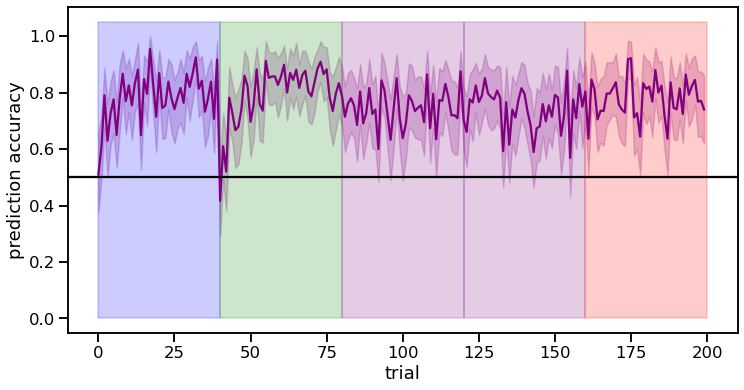

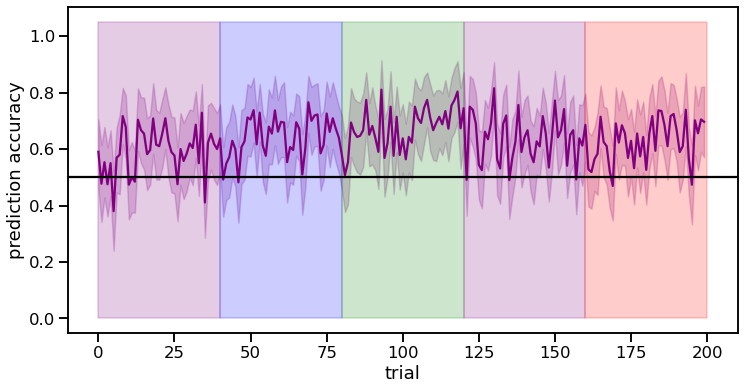

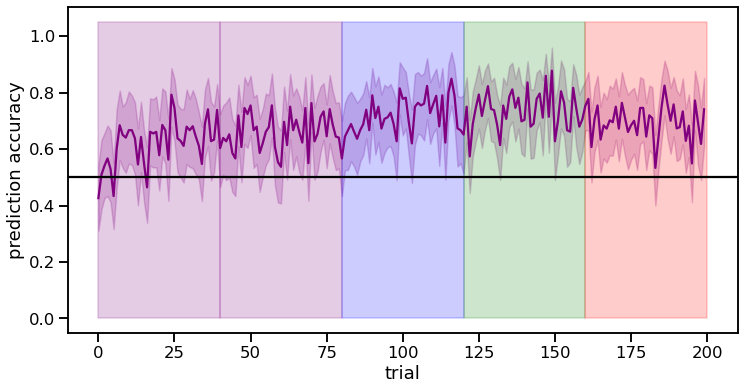

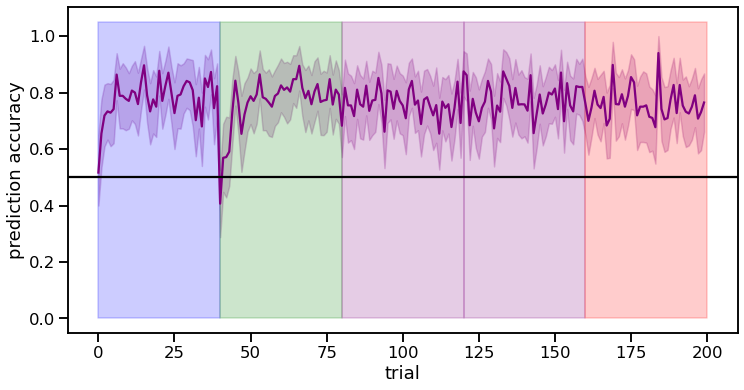

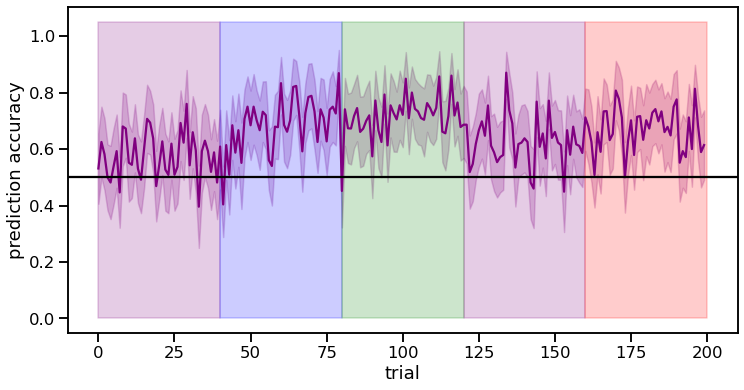

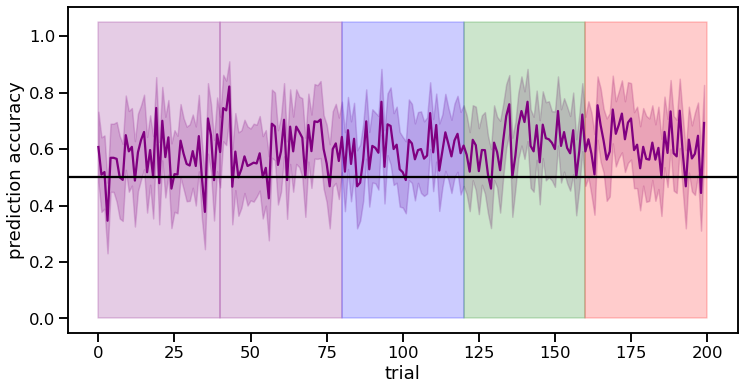

In [40]:
lineplt(cL,0.9,transition=2,fgkw={'color':'purple'})

In [3]:
def plt_silvy_data(df):
  plt.figure(figsize=(12,6))
  ax = plt.gca()
  df.loc[:,"wrong time step"] = df.loc[:,"wrong time step"]/4
  df = df.melt(id_vars='curriculum',value_vars=['correct',"wrong schema", "wrong time step"])
  df.value = df.value/100
#   sns.swarmplot(
#     data=df,
#     x='variable',y='value',hue='curriculum',ax=ax,hue_order=['blocked','interleaved'],
#     dodge=True,color='k'
#   )
#   ax.legend([],[], frameon=False)
  sns.barplot(
    data=df,
    x='variable',y='value',hue='curriculum',ax=ax,hue_order=['blocked','interleaved'],ci=95
  )
#   ax.legend([1,2],[1,2], frameon=False)
  ax.set_ylabel('choice probability')
  ax.set_xlabel('choice')
  ax.set_ylim(0,1.03)

  
## PROCESSSING
A,B = "wrong schema", "wrong time step"
df1 = pd.read_excel("silvydata/Andre_data_onSiteExpt.xlsx")
df1.columns = [*df1.columns[:2],A,B,'curriculum']

## ONSITE PLOT
l = plt_silvy_data(df1)
plt.savefig('silvydata/onsite.png')
plt.savefig('silvydata/onsite.svg')

# PROCESSING 2
df2 = pd.read_excel("silvydata/Andre_data_onlineExpt.xlsx")
df2.columns = ['curriculum',df2.columns[1],A,B]

# ONLINE PLOT
plt_silvy_data(df2)
plt.savefig('silvydata/online.png')
plt.savefig('silvydata/online.svg')

In [34]:
## TTEST
for ix,df in zip(('a','b'),[df2,df1]):
  for sch in ['blocked','interleaved']:
    df_ = df.query(f"curriculum=='{sch}'")
    a = df_.loc[:,('wrong schema','wrong time step')].values[:,0]
    b = df_.loc[:,('wrong schema','wrong time step')].values[:,1]
    print(ix,sch)
    print(ttest_ind(a,b))
    print()

a blocked
Ttest_indResult(statistic=8.84463300597022, pvalue=5.659166111534543e-15)

a interleaved
Ttest_indResult(statistic=8.447719804255003, pvalue=8.111551788995731e-14)

b blocked
Ttest_indResult(statistic=4.18350629858984, pvalue=0.0002564321173504884)

b interleaved
Ttest_indResult(statistic=8.18632250180442, pvalue=6.538754272211748e-09)

